In [ ]:
# ------------------ Step 1: Import Libraries ------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from sklearn.preprocessing import label_binarize

import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Enable mixed precision for faster training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [2]:
# ------------------ Step 2: Data Preprocessing ------------------

IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kneeKL299/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kneeKL299/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/kneeKL299/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 4624 images belonging to 5 classes.
Found 163 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


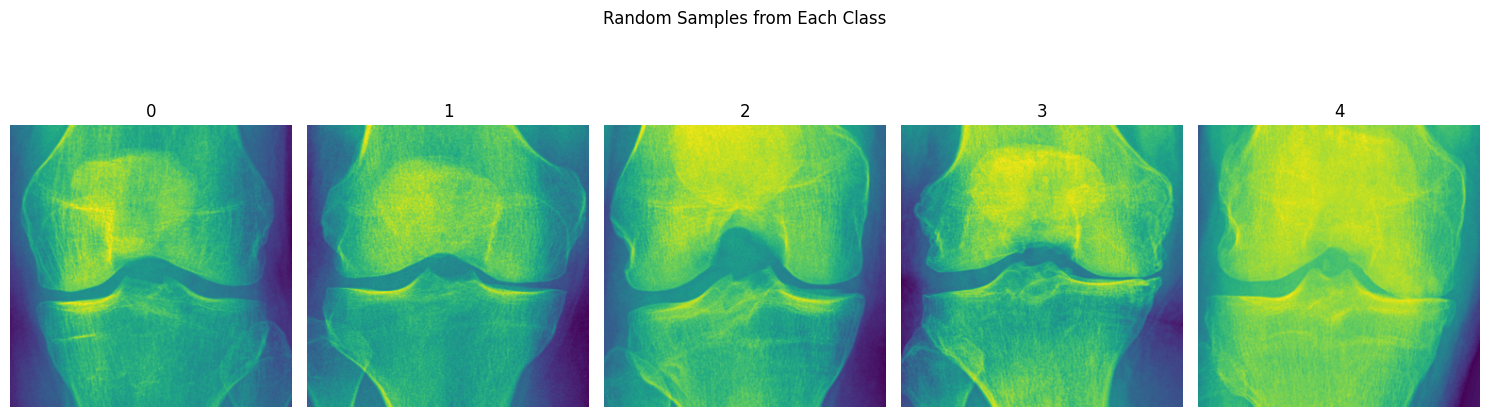

In [3]:
# ------------------ Step 3: Visualize Random Images from Each Class ------------------

def show_random_images_per_class(directory, classes, num_images=1):
    plt.figure(figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        random_images = random.sample(image_files, num_images)
        for j, image_name in enumerate(random_images):
            image_path = os.path.join(class_dir, image_name)
            img = Image.open(image_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.suptitle("Random Samples from Each Class")
    plt.tight_layout()
    plt.show()

class_names = sorted(os.listdir('/content/drive/MyDrive/kneeKL299/train'))
show_random_images_per_class('/content/drive/MyDrive/kneeKL299/train', class_names)

In [4]:
# ------------------ Step 4: Build EfficientNetB7 Model ------------------

base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
out = Dense(len(class_names), activation='softmax', dtype='float32')(x)

effnet_model = Model(inputs=base_model.input, outputs=out)
effnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [5]:
# ------------------ Step 5: Train EfficientNetB7 ------------------

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
checkpoint = ModelCheckpoint('efficientnetb7_best.h5', save_best_only=True)

history_effnet = effnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3532 - loss: 1.4759 

145/145 ━━━━━━━━━━━━━━━━━━━━ 2319s 14s/step - accuracy: 0.3534 - loss: 1.4756 - val_accuracy: 0.3988 - val_loss: 1.5180 - learning_rate: 1.0000e-04
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 105s 707ms/step - accuracy: 0.4661 - loss: 1.2645 - val_accuracy: 0.2577 - val_loss: 1.5889 - learning_rate: 1.0000e-04
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4928 - loss: 1.1550

145/145 ━━━━━━━━━━━━━━━━━━━━ 138s 952ms/step - accuracy: 0.4929 - loss: 1.1549 - val_accuracy: 0.3374 - val_loss: 1.3658 - learning_rate: 1.0000e-04
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.5505 - loss: 1.0724

145/145 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5505 - loss: 1.0723 - val_accuracy: 0.4847 - val_loss: 1.2052 - learning_rate: 1.0000e-04
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.5768 - loss: 0.9925

145/145 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5768 - loss: 0.9925 - val_accuracy: 0.4785 - val_loss: 1.1508 - learning_rate: 1.0000e-04
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 97s 667ms/step - accuracy: 0.5873 - loss: 0.9788 - val_accuracy: 0.1963 - val_loss: 1.9204 - learning_rate: 1.0000e-04
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 654ms/step - accuracy: 0.5937 - loss: 0.9451 - val_accuracy: 0.1902 - val_loss: 2.0860 - learning_rate: 1.0000e-04
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.6112 - loss: 0.9164
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 655ms/step - accuracy: 0.6112 - loss: 0.9164 - val_accuracy: 0.1840 - val_loss: 2.0944 - learning_rate: 1.0000e-04
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6214 - loss: 0.8730

145/145 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6215 - loss: 0.8729 - val_accuracy: 0.5706 - val_loss: 1.0360 - learning_rate: 3.0000e-05
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6450 - loss: 0.8088

145/145 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.6451 - loss: 0.8088 - val_accuracy: 0.6012 - val_loss: 1.0139 - learning_rate: 3.0000e-05
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 126s 653ms/step - accuracy: 0.6518 - loss: 0.8214 - val_accuracy: 0.4908 - val_loss: 1.0695 - learning_rate: 3.0000e-05
Epoch 12/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 653ms/step - accuracy: 0.6783 - loss: 0.7718 - val_accuracy: 0.5583 - val_loss: 1.0686 - learning_rate: 3.0000e-05
Epoch 13/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.6764 - loss: 0.7616
Epoch 13: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 649ms/step - accuracy: 0.6764 - loss: 0.7615 - val_accuracy: 0.4601 - val_loss: 1.0686 - learning_rate: 3.0000e-05
Epoch 14/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 652ms/step - accuracy: 0.6913 - loss: 0.7434 - val_accuracy: 0.5521 - val_loss: 1.0566 - learning_rate: 9.0000e-06
Epoch 15/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - ac

145/145 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6824 - loss: 0.7550 - val_accuracy: 0.5890 - val_loss: 1.0010 - learning_rate: 9.0000e-06
Epoch 16/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 651ms/step - accuracy: 0.7005 - loss: 0.7230 - val_accuracy: 0.5583 - val_loss: 1.1032 - learning_rate: 9.0000e-06
Epoch 17/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 642ms/step - accuracy: 0.7063 - loss: 0.7015 - val_accuracy: 0.5951 - val_loss: 1.0338 - learning_rate: 9.0000e-06
Epoch 18/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6903 - loss: 0.7256
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
145/145 ━━━━━━━━━━━━━━━━━━━━ 94s 644ms/step - accuracy: 0.6904 - loss: 0.7255 - val_accuracy: 0.5399 - val_loss: 1.1133 - learning_rate: 9.0000e-06
Epoch 19/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 654ms/step - accuracy: 0.7206 - loss: 0.6610 - val_accuracy: 0.5521 - val_loss: 1.0097 - learning_rate: 2.7000e-06
Epoch 20/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 95s 653ms/step - a

In [6]:
# ------------------ Step 6: Evaluate EfficientNetB7 ------------------

test_loss, test_acc = effnet_model.evaluate(test_generator, verbose=1)
print(f"EfficientNetB7 Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_generator.classes
y_pred_probs = effnet_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("EfficientNetB7 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 864s 513ms/step - accuracy: 0.6742 - loss: 0.7979
EfficientNetB7 Test Accuracy: 59.78%
1656/1656 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step
EfficientNetB7 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       639
           1       0.31      0.27      0.29       296
           2       0.59      0.50      0.54       447
           3       0.71      0.71      0.71       223
           4       0.74      0.76      0.75        51

    accuracy                           0.60      1656
   macro avg       0.60      0.60      0.60      1656
weighted avg       0.59      0.60      0.59      1656



In [7]:
# ------------------ Step 7: Define PyTorch Dataset for ViT ------------------

class OAIDataset(Dataset):
    def __init__(self, directory, feature_extractor, transform=None):
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(directory))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.feature_extractor = feature_extractor
        self.transform = transform

        for label in self.classes:
            class_dir = os.path.join(directory, label)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        else:
            image = self.feature_extractor(images=image, return_tensors="pt")['pixel_values'].squeeze()
        label = self.labels[idx]
        return image, label

In [8]:
# ------------------ Step 8: Initialize ViT Model and DataLoaders ------------------

# Clear TensorFlow session and release GPU memory before using PyTorch
tf.keras.backend.clear_session()
# Optionally, trigger garbage collection
import gc
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(class_names)
).to(device)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Ensure the validation directory exists or adjust the path if using a validation split from the train directory
# Based on the previous steps using ImageDataGenerator, '/content/drive/MyDrive/kneeKL299/train'
# was used for both training and validation with a split.
# If you have a separate validation directory, use that path.
# Otherwise, you might need to revisit how you handle the validation set for the PyTorch DataLoader.
# For now, assuming '/content/drive/MyDrive/kneeKL299/val' is a valid path or needs adjustment.
# If you used a validation split from the train folder for TensorFlow, you might need to
# manually split the data or use a PyTorch-compatible method for dataset splitting.
# For demonstration purposes, assuming '/content/drive/MyDrive/kneeKL299/val' exists.
val_dataset_path = '/content/drive/MyDrive/kneeKL299/val'
if not os.path.exists(val_dataset_path):
    print(f"Warning: Validation directory '{val_dataset_path}' not found. Please ensure it exists or adjust the path.")
    # As a temporary workaround, you could use the training data for validation in the dataset
    # but this is not ideal for model evaluation.
    # For a proper setup, ensure a separate validation directory or implement a dataset split.
    val_dataset_path = '/content/drive/MyDrive/kneeKL299/train' # TEMPORARY: Use train if val not found


train_dataset = OAIDataset('/content/drive/MyDrive/kneeKL299/train', feature_extractor, transform)
val_dataset = OAIDataset(val_dataset_path, feature_extractor, transform)
test_dataset = OAIDataset('/content/drive/MyDrive/kneeKL299/test', feature_extractor, transform)

VIT_BATCH_SIZE = 16
# Reduce batch size if OOM still occurs during training with ViT
# VIT_BATCH_SIZE = 8 # Example of further reduction

train_loader = DataLoader(train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Enable mixed precision training for PyTorch as well if you haven't already in Step 9
# from torch.cuda.amp import autocast, GradScaler
# scaler = GradScaler() # Initialize scaler

print("ViT model initialized and moved to device.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model initialized and moved to device.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# ------------------ Step 9: Train ViT Model ------------------

from torch.optim import AdamW
from tqdm import tqdm
# Import mixed precision training utilities for PyTorch
from torch.cuda.amp import autocast, GradScaler
import torch # Ensure torch is imported if not already

epochs = 10
optimizer = AdamW(vit_model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Initialize a GradScaler for mixed precision training
scaler = GradScaler()

def train_vit(model, dataloader, optimizer, criterion, scaler):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(dataloader):
        # Clear CUDA cache before transferring data to GPU
        if torch.cuda.is_available():
             torch.cuda.empty_cache()
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Use autocast for mixed precision
        with autocast():
            outputs = model(images).logits
            loss = criterion(outputs, labels)

        # Scale the loss and perform backward pass
        scaler.scale(loss).backward()

        # Unscale gradients and step the optimizer
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

def eval_vit(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        # Use autocast for mixed precision during evaluation as well
        with autocast():
            for images, labels in dataloader:
                 # Clear CUDA cache before transferring data to GPU in eval as well
                if torch.cuda.is_available():
                     torch.cuda.empty_cache()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    return total_loss / total, correct / total


for epoch in range(epochs):
    # Pass the scaler to the train function
    train_loss, train_acc = train_vit(vit_model, train_loader, optimizer, criterion, scaler)
    # Eval function doesn't need scaler
    val_loss, val_acc = eval_vit(vit_model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

<ipython-input-9-7b528e391571>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/362 [00:00<?, ?it/s]<ipython-input-9-7b528e391571>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 362/362 [02:13<00:00,  2.72it/s]
<ipython-input-9-7b528e391571>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 - Train loss: 1.1602, Train acc: 0.5187, Val loss: 0.9861, Val acc: 0.5908


100%|██████████| 362/362 [01:18<00:00,  4.64it/s]


Epoch 2/10 - Train loss: 0.8708, Train acc: 0.6478, Val loss: 0.8947, Val acc: 0.6308


100%|██████████| 362/362 [01:18<00:00,  4.62it/s]


Epoch 3/10 - Train loss: 0.7417, Train acc: 0.7023, Val loss: 0.8833, Val acc: 0.6211


100%|██████████| 362/362 [01:17<00:00,  4.65it/s]


Epoch 4/10 - Train loss: 0.6290, Train acc: 0.7449, Val loss: 0.8826, Val acc: 0.6344


100%|██████████| 362/362 [01:17<00:00,  4.65it/s]


Epoch 5/10 - Train loss: 0.5085, Train acc: 0.8032, Val loss: 0.9586, Val acc: 0.6211


100%|██████████| 362/362 [01:18<00:00,  4.62it/s]


Epoch 6/10 - Train loss: 0.3973, Train acc: 0.8560, Val loss: 1.0988, Val acc: 0.6211


100%|██████████| 362/362 [01:18<00:00,  4.63it/s]


Epoch 7/10 - Train loss: 0.3171, Train acc: 0.8887, Val loss: 1.1020, Val acc: 0.6077


100%|██████████| 362/362 [01:17<00:00,  4.65it/s]


Epoch 8/10 - Train loss: 0.2439, Train acc: 0.9183, Val loss: 1.2385, Val acc: 0.5908


100%|██████████| 362/362 [01:17<00:00,  4.65it/s]


Epoch 9/10 - Train loss: 0.1952, Train acc: 0.9384, Val loss: 1.3918, Val acc: 0.5835


100%|██████████| 362/362 [01:18<00:00,  4.63it/s]


Epoch 10/10 - Train loss: 0.1576, Train acc: 0.9508, Val loss: 1.4645, Val acc: 0.5714


In [10]:
# ------------------ Step 10: Evaluate ViT on Test Set ------------------

vit_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy()[0])
        all_labels.append(labels.numpy()[0])

print("ViT Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

vit_test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"ViT Test Accuracy: {vit_test_acc * 100:.2f}%")



ViT Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.49      0.61       639
           1       0.29      0.57      0.39       296
           2       0.64      0.61      0.62       447
           3       0.79      0.78      0.78       223
           4       0.90      0.69      0.78        51

    accuracy                           0.58      1656
   macro avg       0.68      0.63      0.64      1656
weighted avg       0.67      0.58      0.60      1656

ViT Test Accuracy: 58.39%


In [11]:
# ------------------ Step 11: Ensemble Predictions ------------------

# Predict with EfficientNet
effnet_preds = np.argmax(effnet_model.predict(test_generator), axis=1)

# Combine predictions by averaging probabilities (soft voting)
vit_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = vit_model(images).logits
        vit_probs.append(torch.softmax(outputs, dim=1).cpu().numpy()[0])
vit_probs = np.array(vit_probs)

effnet_probs = effnet_model.predict(test_generator)

ensemble_probs = (effnet_probs + vit_probs) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)

print("Ensemble Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=class_names))

ensemble_test_acc = np.mean(ensemble_preds == y_true)
print(f"Ensemble Test Accuracy: {ensemble_test_acc * 100:.2f}%")

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 47s 26ms/step


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1656/1656 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step
Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       639
           1       0.33      0.53      0.41       296
           2       0.70      0.66      0.68       447
           3       0.85      0.85      0.85       223
           4       0.89      0.82      0.86        51

    accuracy                           0.65      1656
   macro avg       0.71      0.70      0.70      1656
weighted avg       0.70      0.65      0.67      1656

Ensemble Test Accuracy: 65.16%


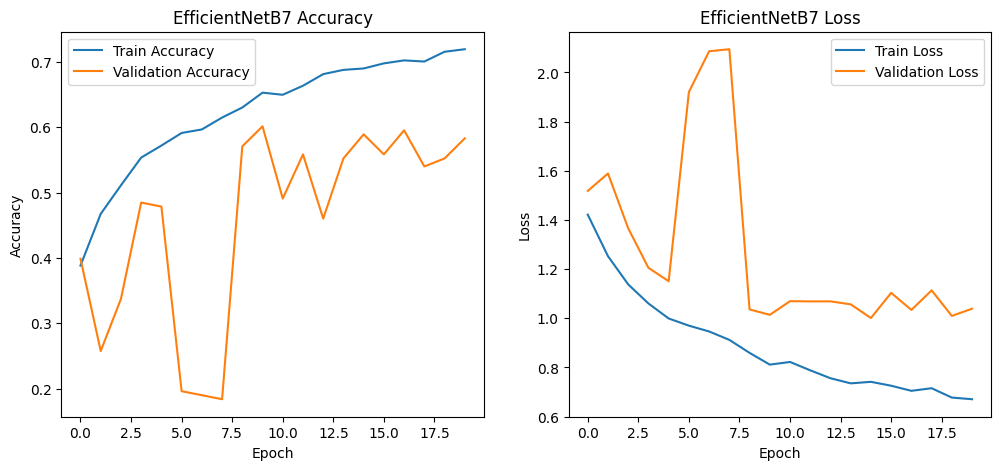

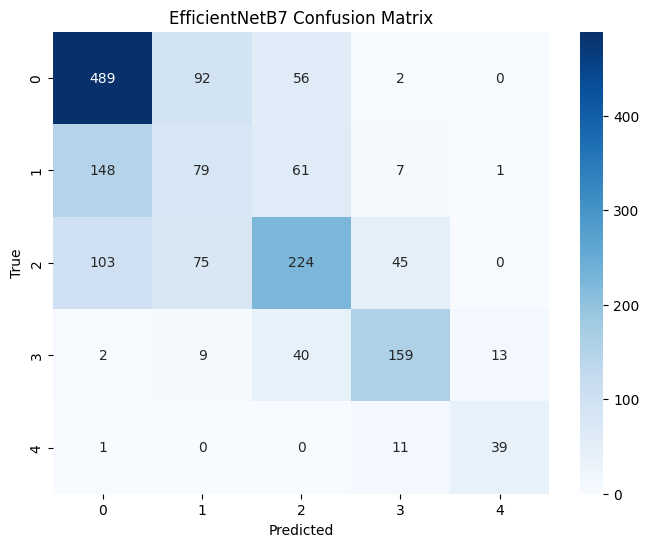

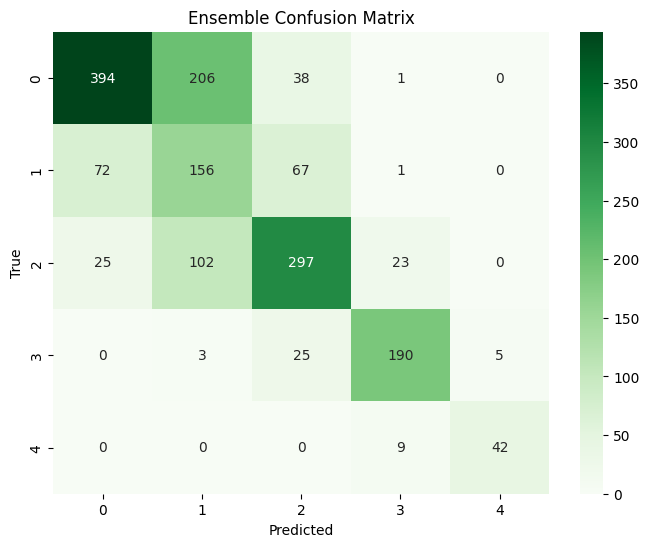

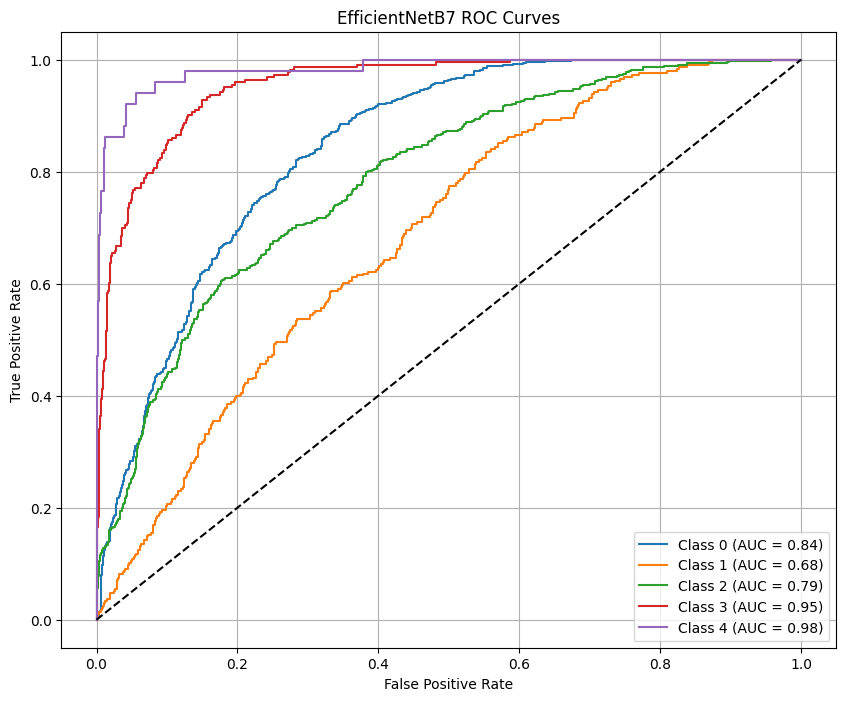

In [12]:
# ------------------ Step 12: Plot Metrics (Accuracy, Loss, Confusion Matrix, ROC) ------------------

# Plot training & validation accuracy & loss for EfficientNet
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB7 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_effnet.history['loss'], label='Train Loss')
plt.plot(history_effnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB7 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion matrix for EfficientNet
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB7 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion matrix for Ensemble
cm_ensemble = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve for EfficientNet
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB7 ROC Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()